In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import math
from sklearn.metrics import classification_report

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

from datasets import load_dataset
dataset = load_dataset("dair-ai/emotion")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HanDong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HanDong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df_train = pd.DataFrame(dataset['train'])
df_val = pd.DataFrame(dataset['validation'])
df_test = pd.DataFrame(dataset['test'])

print("train set:", df_train.shape)
print("valid set:", df_val.shape)
print("test set:", df_test.shape)
df_train

train set: (16000, 2)
valid set: (2000, 2)
test set: (2000, 2)


,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


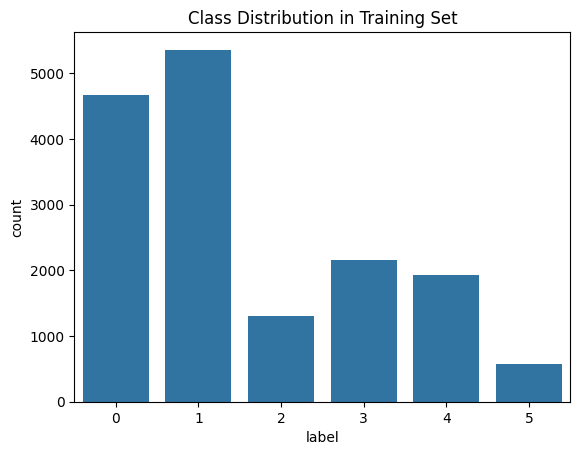

In [3]:
sns.countplot(x='label', data=df_train)
plt.title("Class Distribution in Training Set")
plt.show()

# Preprocessing

In [ ]:
# Text Cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df_train['clean_text'] = df_train['text'].apply(clean_text)
df_val['clean_text'] = df_val['text'].apply(clean_text)
df_test['clean_text'] = df_test['text'].apply(clean_text)

df_train

,text,label,clean_text
0,i didnt feel humiliated,0,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,0,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,3,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,2,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,3,feeling grouchy
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,0,turning feel pathetic still waiting table subb...
15997,i feel strong and good overall,1,feel strong good overall
15998,i feel like this was such a rude comment and i...,3,feel like rude comment im glad


In [5]:
# Concatenate all rows of cleaned text into one big string, then splits it into tokens
all_text = ' '.join(df_train['clean_text']).split()

# Get a list of unique words (vocabulary)
vocab = ['<PAD>', '<UNK>'] + list(dict(Counter(all_text)).keys())
vocab_size = len(vocab)
print("Vocabulary size:", vocab_size)

# Mapping each word to an index
word2idx = {w: i for i, w in enumerate(vocab)}

# Encode
def encode(text, max_len=35):
    tokens = text.split()
    ids = [word2idx.get(w, word2idx['<UNK>']) for w in tokens]  # Use index 1 for unknown or out-of-vocabulary words
    return ids[:max_len] + [word2idx['<PAD>']] * max(0, max_len - len(ids))  # If too short, pad with index 0

X_train = [encode(t) for t in df_train['clean_text']]
X_val = [encode(t) for t in df_val['clean_text']]
X_test = [encode(t) for t in df_test['clean_text']]
y_train = df_train['label'].tolist()
y_val = df_val['label'].tolist()
y_test = df_test['label'].tolist()

Vocabulary size: 13484


In [6]:
# Create Dataset and DataLoader
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(EmotionDataset(X_train, y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(EmotionDataset(X_val, y_val), batch_size=64)
test_loader = DataLoader(EmotionDataset(X_test, y_test), batch_size=64)

# Transformer Encoder

In [7]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, nhead=4, ff_dim=256, num_layers=1, num_classes=6):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoding = PositionalEncoding(embed_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=nhead, dim_feedforward=ff_dim)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.embedding(x)  # (batch, seq_len, embed_dim)
        x = self.pos_encoding(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch, embed_dim) for transformer
        x = self.transformer(x)
        x = x.mean(dim=0)  # average pooling
        return self.classifier(x)


In [8]:
# Train the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerClassifier(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

accuracies = {
    "train accuracy": [],
    "valid accuracy": []
}
losses = {
    "train loss": [],
    "valid loss": []
}

def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        # Train
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == y).sum().item()
            train_total += y.size(0)

        avg_train_loss = train_loss / train_total
        train_accuracy = train_correct / train_total
        accuracies["train accuracy"].append(train_accuracy)
        losses["train loss"].append(avg_train_loss)

        # Validation
        model.eval()
        valid_loss, valid_correct, valid_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)

                valid_loss += loss.item() * X.size(0)
                _, predicted = torch.max(outputs, 1)
                valid_correct += (predicted == y).sum().item()
                valid_total += y.size(0)

        avg_valid_loss = valid_loss / valid_total
        valid_accuracy = valid_correct / valid_total
        accuracies["valid accuracy"].append(valid_accuracy)
        losses["valid loss"].append(avg_valid_loss)

        current_lr = optimizer.param_groups[0]["lr"]

        print(f"Epoch {epoch+1}/{epochs} | "
            f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {train_accuracy:.2%} | "
            f"Val Loss: {avg_valid_loss:.4f} | Val Accuracy: {valid_accuracy:.2%} | "
            f"Learning rate: {current_lr:.4f}")

train_model(model, train_loader, val_loader, epochs=10)

c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10 | Train Loss: 1.4802 | Train Accuracy: 39.65% | Val Loss: 1.0920 | Val Accuracy: 60.15% | Learning rate: 0.0010
Epoch 2/10 | Train Loss: 0.7619 | Train Accuracy: 72.91% | Val Loss: 0.5914 | Val Accuracy: 79.55% | Learning rate: 0.0010
Epoch 3/10 | Train Loss: 0.4338 | Train Accuracy: 85.27% | Val Loss: 0.4776 | Val Accuracy: 82.95% | Learning rate: 0.0010
Epoch 4/10 | Train Loss: 0.2962 | Train Accuracy: 89.79% | Val Loss: 0.4476 | Val Accuracy: 84.70% | Learning rate: 0.0010
Epoch 5/10 | Train Loss: 0.2240 | Train Accuracy: 92.02% | Val Loss: 0.4187 | Val Accuracy: 85.65% | Learning rate: 0.0010
Epoch 6/10 | Train Loss: 0.1743 | Train Accuracy: 93.58% | Val Loss: 0.4231 | Val Accuracy: 86.15% | Learning rate: 0.0010
Epoch 7/10 | Train Loss: 0.1418 | Train Accuracy: 94.83% | Val Loss: 0.4326 | Val Accuracy: 86.70% | Learning rate: 0.0010
Epoch 8/10 | Train Loss: 0.1230 | Train Accuracy: 95.35% | Val Loss: 0.4630 | Val Accuracy: 86.35% | Learning rate: 0.0010
Epoch 9/10 | Tra

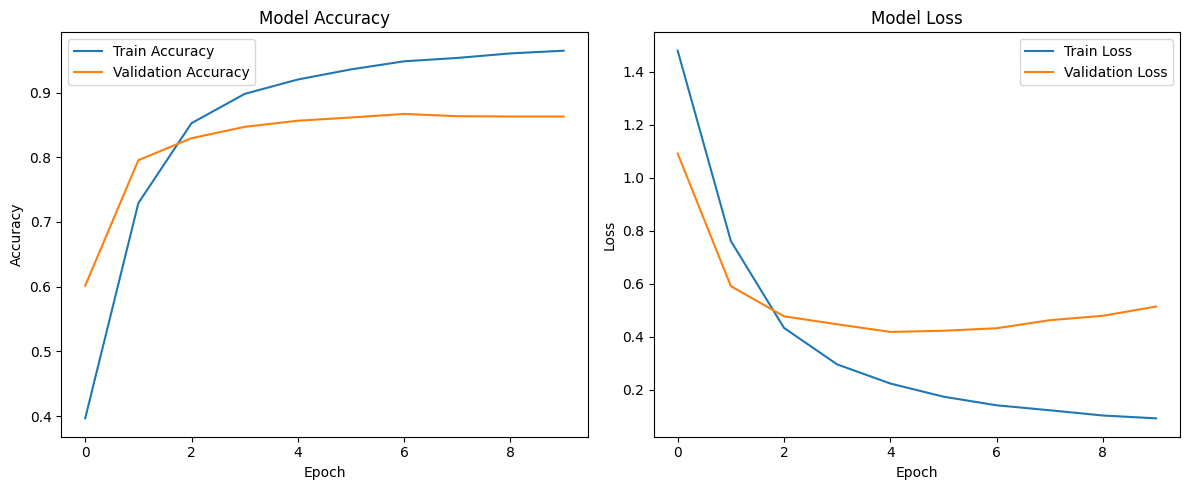

In [9]:
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(accuracies["train accuracy"], label='Train Accuracy')
plt.plot(accuracies["valid accuracy"], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(losses['train loss'], label='Train Loss')
plt.plot(losses['valid loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Evaluate on Test Set
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

class_names = dataset['train'].features['label'].names

# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

     sadness       0.91      0.88      0.89       581
         joy       0.85      0.94      0.89       695
        love       0.84      0.57      0.68       159
       anger       0.84      0.88      0.86       275
        fear       0.82      0.81      0.81       224
    surprise       0.72      0.59      0.65        66

    accuracy                           0.86      2000
   macro avg       0.83      0.78      0.80      2000
weighted avg       0.86      0.86      0.85      2000



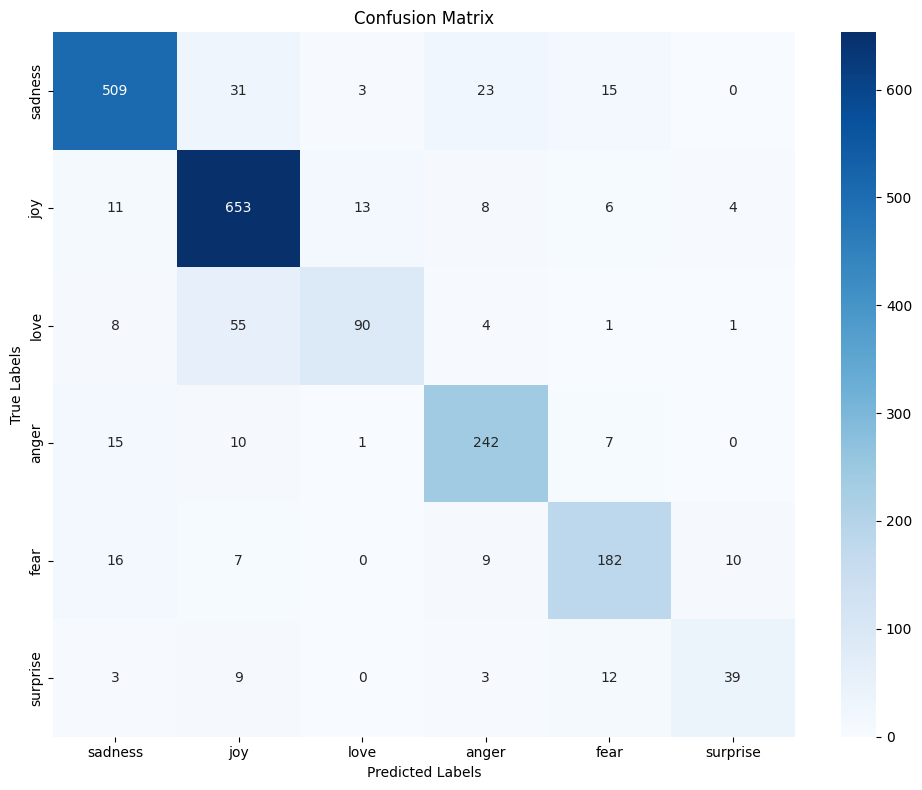

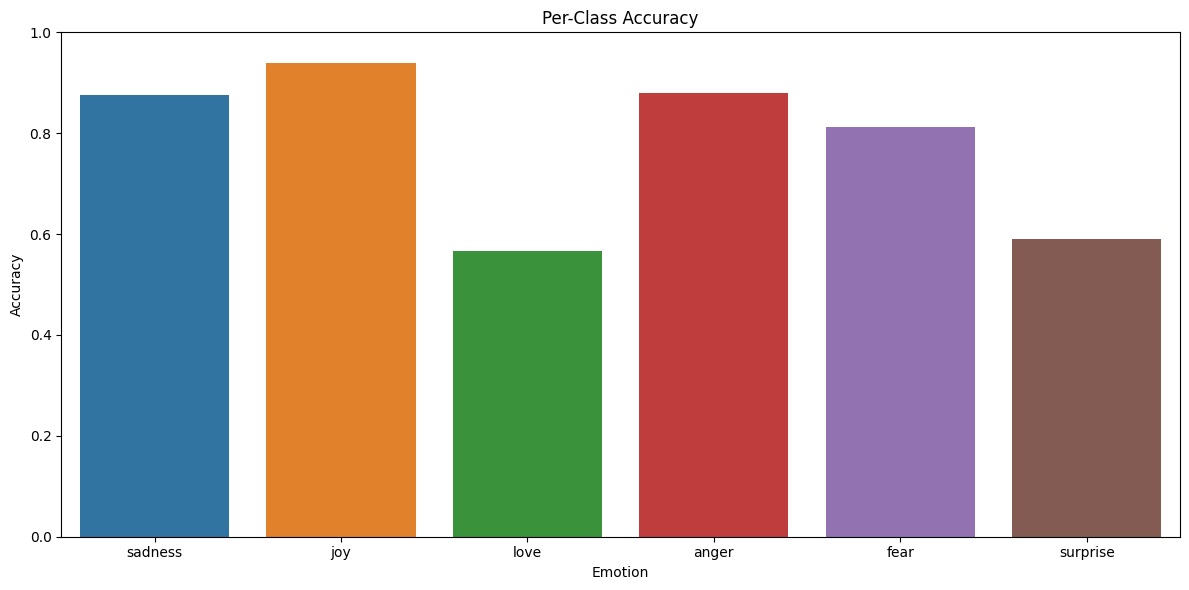

In [11]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Plot per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=per_class_accuracy, hue=class_names)
plt.xlabel('Emotion')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [12]:
# Show False Predictions
df_test['predicted'] = all_preds
false_cases = df_test[df_test['label'] != df_test['predicted']]
false_cases[['text', 'label', 'predicted']]

,text,label,predicted
6,i felt anger when at the end of a telephone call,3,1
10,i don t feel particularly agitated,4,3
11,i feel beautifully emotional knowing that thes...,0,1
20,im not sure the feeling of loss will ever go a...,0,2
49,i was feeling pretty anxious all day but my fi...,4,1
...,...,...,...
1959,i check you when you re sleeping feel your nos...,1,3
1961,i remember wanting to fit in so bad and feelin...,2,0
1967,i see how it turns out i ll talk more about it...,1,4
1970,i guess as long as the table in the above is p...,2,1


In [13]:
# Inference on New Inputs
def predict_emotion(text):
    text = clean_text(text)
    tokens = encode(text)
    input_tensor = torch.tensor(tokens).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = output.argmax(dim=1).item()
    return dataset['train'].features['label'].int2str(pred)

print(predict_emotion("I am so scared right now."))
print(predict_emotion("I'm feeling very nervous and anxious about the results."))
print(predict_emotion("I am so excited for tomorrow!"))

fear
fear
joy


# RoBERTa + LoRA

In [14]:
from transformers import RobertaForSequenceClassification, RobertaTokenizer, TrainingArguments, Trainer, TrainerCallback
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=6)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    target_modules=["query", "value"],
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Preprocess with Tokenizer
def preprocess(text):
    return tokenizer(text['text'], truncation=True, padding="max_length", max_length=64)

dataset = dataset.rename_column("label", "labels")
tokenized_dataset = dataset.map(preprocess, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Apply LoRA with peft
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

trainable params: 890,118 || all params: 125,540,364 || trainable%: 0.7090


In [16]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [17]:
# Training Setup
class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.epoch_logs = []

    def on_epoch_end(self, args, state, control, **kwargs):
        train_loss = None
        eval_loss = None
        eval_accuracy = None
        learning_rate = None

        # Iterate through log_history to find the relevant logs for the epoch
        for log_entry in state.log_history:
            if "loss" in log_entry and log_entry.get("step", None) is not None: # training loss has a step
                 train_loss = log_entry["loss"]
            elif "eval_loss" in log_entry: # evaluation loss doesn't have a step
                 eval_loss = log_entry["eval_loss"]
                 eval_accuracy = log_entry.get("eval_accuracy", None)
                 learning_rate = log_entry.get("learning_rate", None)

        logs = {
            "epoch": state.epoch,
            "train_loss": train_loss,
            "eval_loss": eval_loss,
            "eval_accuracy": eval_accuracy,
            "learning_rate": learning_rate,
        }
        self.epoch_logs.append(logs)

log_callback = LoggingCallback()

training_args = TrainingArguments(
    output_dir="./roberta_results",
    label_names=["labels"],
    eval_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[log_callback]
)

In [18]:
# Train
trainer.train()
log_data = log_callback.epoch_logs
df_logs = pd.DataFrame(log_data)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: huynhhandong (huynhhandong-fpt-university). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,1.375777,0.521000,0.328505,0.521000,0.402620
2,1.348300,0.882351,0.690000,0.660720,0.690000,0.655462
3,1.348300,0.729424,0.738500,0.746527,0.738500,0.719982
4,0.793900,0.645661,0.768500,0.771240,0.768500,0.759597
5,0.793900,0.592204,0.787000,0.789192,0.787000,0.782295
6,0.654800,0.560790,0.793500,0.794789,0.793500,0.789040
7,0.654800,0.533709,0.804500,0.806084,0.804500,0.801648
8,0.591900,0.516586,0.812000,0.812594,0.812000,0.808715
9,0.591900,0.506564,0.812500,0.812920,0.812500,0.809678
10,0.569800,0.504707,0.815000,0.815524,0.815000,0.812163


c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


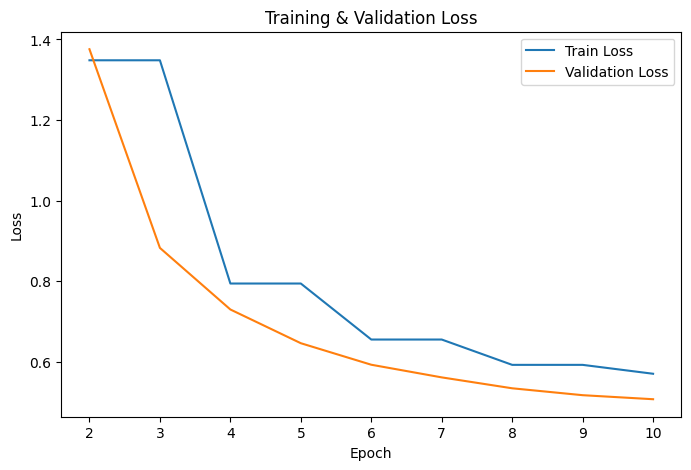

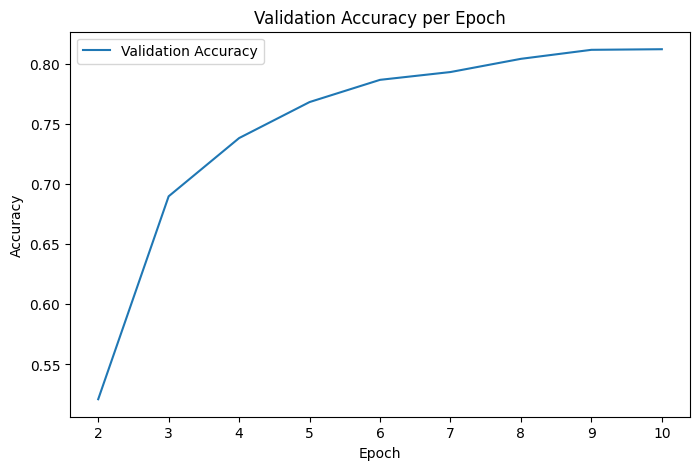

In [19]:
# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(df_logs["epoch"], df_logs["train_loss"], label="Train Loss")
plt.plot(df_logs["epoch"], df_logs["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

print()
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(df_logs["epoch"], df_logs["eval_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.legend()
plt.show()

In [20]:
# Evaluate on Test Set
metrics = trainer.evaluate(tokenized_dataset["test"])
performance = pd.DataFrame([metrics])
performance

,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.49374,0.8155,0.815249,0.8155,0.812969,2.8368,705.025,11.28,10.0


In [21]:
# Show False Predictions
preds = trainer.predict(tokenized_dataset["test"])
pred_labels = torch.tensor(preds.predictions).argmax(-1).numpy()
true_labels = tokenized_dataset["test"]["labels"]

false_indices = [i for i, (p, t) in enumerate(zip(pred_labels, true_labels)) if p != t]
for i in false_indices[:5]:
    print("Text:", dataset["test"][i]["text"])
    print("True:", dataset["test"].features["labels"].int2str(true_labels[i].item()))
    print("Pred:", dataset["test"].features["labels"].int2str(pred_labels[i].item()))
    print()

Text: im feeling rather rotten so im not very ambitious right now
True: sadness
Pred: anger

Text: i don t feel particularly agitated
True: fear
Pred: anger

Text: i feel beautifully emotional knowing that these women of whom i knew just a handful were holding me and my baba on our journey
True: sadness
Pred: love

Text: i pay attention it deepens into a feeling of being invaded and helpless
True: fear
Pred: sadness

Text: i also know that i feel nothing than a friendly affection to them too
True: joy
Pred: love



In [22]:
# Inference on New Inputs
def predict_emotion(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}  # Move tensors to the same device as the model
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = logits.argmax(-1).item()
    return dataset["train"].features["labels"].int2str(pred)

print(predict_emotion("I am so scared right now."))
print(predict_emotion("I'm feeling very nervous and anxious about the results."))
print(predict_emotion("I am so excited for tomorrow!"))

fear
fear
joy


## Compare Parameter Sizes

In [23]:
# Full model parameters
full_model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=6)
full_total = sum(p.numel() for p in full_model.parameters())

# LoRA model trainable parameters
lora_total = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Full RoBERTa params: {full_total:,}")
print(f"LoRA-trainable params: {lora_total:,}")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Full RoBERTa params: 124,650,246
LoRA-trainable params: 890,118


# DistilBERT

In [24]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

c:\Users\HanDong\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\HanDong\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Fallin

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [25]:
# Preprocess with Tokenizer
def preprocess(text):
    return tokenizer(text["text"], truncation=True, padding="max_length", max_length=64)

encoded_dataset = dataset.map(preprocess, batched=True)
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [26]:
# Training Setup
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    label_names=["labels"],
    eval_strategy="epoch",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=True,
    logging_dir="./logs",
)

log_callback = LoggingCallback()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    compute_metrics=compute_metrics,
    callbacks=[log_callback]
)

In [27]:
# Train
trainer.train()
log_data = log_callback.epoch_logs
df_logs = pd.DataFrame(log_data)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.260777,0.920000,0.923191,0.920000,0.920861
2,0.484400,0.158038,0.936500,0.936919,0.936500,0.936211
3,0.484400,0.144138,0.940000,0.942511,0.940000,0.940609
4,0.118900,0.147507,0.940500,0.940775,0.940500,0.940332
5,0.118900,0.142372,0.939500,0.941092,0.939500,0.939740
6,0.078600,0.161479,0.936500,0.937254,0.936500,0.936724
7,0.078600,0.168073,0.938500,0.938283,0.938500,0.937740
8,0.053300,0.168612,0.938000,0.938732,0.938000,0.938286
9,0.053300,0.175810,0.940000,0.940764,0.940000,0.940086
10,0.037000,0.174445,0.941500,0.941709,0.941500,0.941570


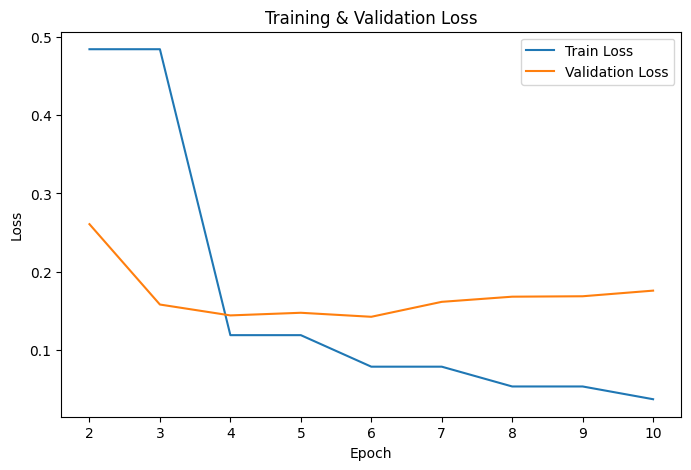

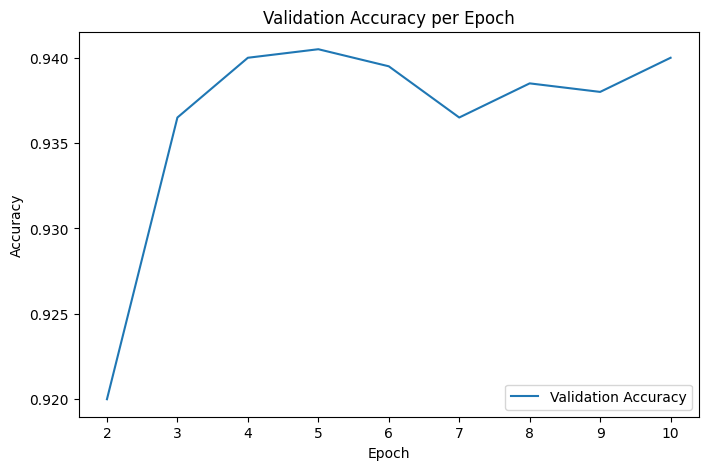

In [28]:
# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(df_logs["epoch"], df_logs["train_loss"], label="Train Loss")
plt.plot(df_logs["epoch"], df_logs["eval_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

print()
# Plot Accuracy
plt.figure(figsize=(8, 5))
plt.plot(df_logs["epoch"], df_logs["eval_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.legend()
plt.show()

In [29]:
# Evaluate on Test Set
metrics = trainer.evaluate(encoded_dataset["test"])
performance = pd.DataFrame([metrics])
performance

,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.212387,0.927,0.928139,0.927,0.927352,1.4452,1383.86,22.142,10.0


In [30]:
# Show False Predictions
preds = trainer.predict(encoded_dataset["test"])
pred_labels = torch.tensor(preds.predictions).argmax(-1).numpy()
true_labels = encoded_dataset["test"]["labels"]

false_indices = [i for i, (p, t) in enumerate(zip(pred_labels, true_labels)) if p != t]
for i in false_indices[:5]:
    print("Text:", dataset["test"][i]["text"])
    print("True:", dataset["test"].features["labels"].int2str(true_labels[i].item()))
    print("Pred:", dataset["test"].features["labels"].int2str(pred_labels[i].item()))
    print()

Text: i don t feel particularly agitated
True: fear
Pred: anger

Text: i feel if i completely hated things i d exercise my democratic right speak my mind in what ever ways possible and try to enact a change
True: anger
Pred: sadness

Text: i am right handed however i play billiards left handed naturally so me trying to play right handed feels weird
True: surprise
Pred: fear

Text: i feel like i am in paradise kissing those sweet lips make me feel like i dive into a magical world of love
True: joy
Pred: love

Text: when a friend dropped a frog down my neck
True: anger
Pred: fear



In [31]:
# Run Inference on New Inputs
def predict_emotion(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=64)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}  # Move tensors to the same device as the model
    with torch.no_grad():
        logits = model(**inputs).logits
        pred = logits.argmax(-1).item()
    return dataset["train"].features["labels"].int2str(pred)

print(predict_emotion("I am so scared right now."))
print(predict_emotion("I'm feeling very nervous and anxious about the results."))
print(predict_emotion("I am so excited for tomorrow!"))

fear
fear
joy
